## Set up

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import MultiTaskElasticNet
from sklearn.metrics import mean_squared_error, roc_auc_score
import seaborn as sns

from fit import fit_categorical_survival, categorical_signal
from models import MergeRareCategories
from pipelines import benchmark_pipelines, build_classifier_pipelines, build_regression_pipelines, categorical_input_columns, evaluate_training_size_dependence, pipelines, reconstruct_categorical_variable_names_Richard
from source import read_preprocessed_data
from transform import load_process_and_store_spreadsheets, survival_histograms
from views import categorical_signal_summary, plot_confusion_matrix, view_as_exponential, view_decision_tree_julian, view_linear_model_richard

In [2]:
def harmonic_mean(t0, t1):
    return t0 * t1 / (t0 + t1)

In [3]:
load_process_and_store_spreadsheets(transformation=harmonic_mean)

X_train, y_train = read_preprocessed_data("output/train.tsv")
X_test, y_test = read_preprocessed_data("output/test.tsv")

## Overall survival and progression free survival
### Population results
To first get an idea of the overall factors, we have a brief look at the data as a whole.

In [4]:
# Combined set for analysis only (not to be used for models).
X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

First calculate distribution of the overall survival (OS) and progression free survival (PFS) and the cumulative distribution.

In [5]:
# Calculate the distribution and cumulative distribution for:
# 1) overall survival.
(t_OS, p_OS), (t_OS_cum, p_OS_cum) = survival_histograms(y['OS_days'], hist_bins=10, cum_hist_bins=15)
# 2) progression free survival.
(t_PFS, p_PFS), (t_PFS_cum, p_PFS_cum) = survival_histograms(y['PFS_days'], hist_bins=10, cum_hist_bins=15)

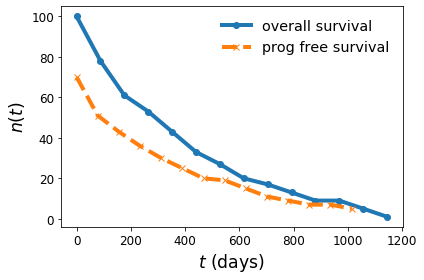

In [6]:
plt.figure()
plt.plot(t_OS_cum, p_OS_cum, '-o', label='overall survival')
plt.plot(t_PFS_cum, p_PFS_cum, '--x', label='prog free survival')
plt.xlabel('$t$ (days)')
plt.ylabel('$n(t)$')
plt.legend(frameon=False)

which clearly shows an exponentially decaying function (as a side note, if the original distribution is exponential, than so is the cumulative function). 

If patients indeed decay exponentially
$$N(t) = N_0 \exp\left(-\frac{t}{\tau}\ln 2\right) ,$$
then the half life $\tau$ can be determined from the slope
$$
\ln[N(t)] = -\frac{\ln 2}{\tau} t + \ln N_0.
$$
Let us fit this to the distribution:


(-22.88, 1166.88)

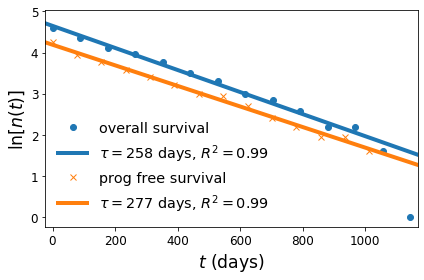

In [7]:
# The last datum is an outlier.
outliers = [len(p_OS_cum) - 1]
view_as_exponential(t_OS_cum, p_OS_cum, outlier_indices=outliers, markers=['o', '-'], label='overall survival')
view_as_exponential(t_PFS_cum, p_PFS_cum, markers=['x', '-'], label='prog free survival')
plt.gca()
dt = t_OS_cum[-1] - t_OS_cum[0]
plt.xlim([t_OS_cum[0] - 0.02*dt, t_OS_cum[-1] + 0.02*dt])

### Phenotype differences
Two exponentials form approximately an exponential
$$
\frac{n_1}{N} e^{-\alpha_1 t} + \frac{n_2}{N} e^{-\alpha_2 t} \approx \exp\left(-\frac{n_1}{N}\alpha_1 t - \frac{n_2}{N}\alpha_2t \right) \equiv \exp(-\alpha t) ,
$$
with $N=n_1 + n_2$, when $n_2(\alpha_1 - \alpha_2)/N t \ll 1$ for relevant $t$. That is, our new $\alpha$ is a weighted average of the individual ones.

In [8]:
# First merge all categories that occur less than 30 times.
X = MergeRareCategories(thresshold=30, categorical_columns=categorical_input_columns).fit_transform(X)

In [9]:
effect_summary = categorical_signal_summary(X, y['OS_days'], categorical_input_columns)

In [10]:
effect_summary.round(2)

delta tau  \
category            item                                                            
gender              male-female                                             41.57   
stage               4-3                                                     72.54   
therapyline         2-1+3+0+4                                               34.61   
smokingstatus       smoker-previous                                        126.92   
                    smoker-unknown+non smoker                              166.78   
                    previous-unknown+non smoker                             39.86   
Systemischetherapie pembrolizumab+nivolumab + ipilimumab+atezolizum...      40.11   
histology_grouped   adeno-squamous                                          30.27   
                    adeno-other                                             70.38   
                    squamous-other                                         100.65   
lymfmeta            metastasis present-no metastasis present               111.70   
brainmeta           metastasis present-no metastasis present                33.18   
adrenalmeta         no metastasis present-metastasis present                42.00   
livermeta           no metastasis present-metastasis present                51.22   
lungmeta            no metastasis present-metastasis present                19.66   
skeletonmeta        no metastasis present-metastasis present                 2.90   

                                                                        signal to noise  
category            item                                                                 
gender              male-female                                                    0.14  
stage               4-3                                                            0.24  
therapyline         2-1+3+0+4                                                      0.11  
smokingstatus       smoker-previous                                                0.41  
                    smoker-unknown+non smoker                                      0.55  
                    previous-unknown+non smoker                                    0.13  
Systemischetherapie pembrolizumab+nivolumab + ipilimumab+atezolizum...             0.13  
histology_grouped   adeno-squamous                                                 0.10  
                    adeno-other                                                    0.23  
                    squamous-other                                                 0.33  
lymfmeta            metastasis present-no metastasis present                       0.37  
brainmeta           metastasis present-no metastasis present                       0.11  
adrenalmeta         no metastasis present-metastasis present                       0.14  
livermeta           no metastasis present-metastasis present                       0.17  
lungmeta            no metastasis present-metastasis present                       0.06  
skeletonmeta        no metastasis present-metastasis present                       0.01

In [11]:
effect_summary.round(2)

delta tau  \
category            item                                                            
gender              male-female                                             41.57   
stage               4-3                                                     72.54   
therapyline         2-1+3+0+4                                               34.61   
smokingstatus       smoker-previous                                        126.92   
                    smoker-unknown+non smoker                              166.78   
                    previous-unknown+non smoker                             39.86   
Systemischetherapie pembrolizumab+nivolumab + ipilimumab+atezolizum...      40.11   
histology_grouped   adeno-squamous                                          30.27   
                    adeno-other                                             70.38   
                    squamous-other                                         100.65   
lymfmeta            metastasis present-no metastasis present               111.70   
brainmeta           metastasis present-no metastasis present                33.18   
adrenalmeta         no metastasis present-metastasis present                42.00   
livermeta           no metastasis present-metastasis present                51.22   
lungmeta            no metastasis present-metastasis present                19.66   
skeletonmeta        no metastasis present-metastasis present                 2.90   

                                                                        signal to noise  
category            item                                                                 
gender              male-female                                                    0.14  
stage               4-3                                                            0.24  
therapyline         2-1+3+0+4                                                      0.11  
smokingstatus       smoker-previous                                                0.41  
                    smoker-unknown+non smoker                                      0.55  
                    previous-unknown+non smoker                                    0.13  
Systemischetherapie pembrolizumab+nivolumab + ipilimumab+atezolizum...             0.13  
histology_grouped   adeno-squamous                                                 0.10  
                    adeno-other                                                    0.23  
                    squamous-other                                                 0.33  
lymfmeta            metastasis present-no metastasis present                       0.37  
brainmeta           metastasis present-no metastasis present                       0.11  
adrenalmeta         no metastasis present-metastasis present                       0.14  
livermeta           no metastasis present-metastasis present                       0.17  
lungmeta            no metastasis present-metastasis present                       0.06  
skeletonmeta        no metastasis present-metastasis present                       0.01

In [12]:
effect_summary = categorical_signal_summary(X, y['PFS_days'], categorical_input_columns)
effect_summary

delta tau  \
category            item                                                              
gender              male-female                                           76.857223   
stage               4-3                                                   88.992372   
therapyline         2-1+3+0+4                                             67.309618   
smokingstatus       smoker-previous                                      128.607674   
                    smoker-unknown+non smoker                             89.222131   
                    previous-unknown+non smoker                           39.385543   
Systemischetherapie pembrolizumab+nivolumab + ipilimumab+atezolizum...   120.587861   
histology_grouped   adeno-squamous                                       120.550463   
                    adeno-other                                          919.561238   
                    squamous-other                                      1040.111701   
lymfmeta            metastasis present-no metastasis present              58.361391   
brainmeta           metastasis present-no metastasis present             124.986322   
adrenalmeta         no metastasis present-metastasis present              20.847962   
livermeta           no metastasis present-metastasis present              74.120479   
lungmeta            no metastasis present-metastasis present             135.486915   
skeletonmeta        no metastasis present-metastasis present             138.435099   

                                                                        signal to noise  
category            item                                                                 
gender              male-female                                                0.266818  
stage               4-3                                                        0.308947  
therapyline         2-1+3+0+4                                                  0.233673  
smokingstatus       smoker-previous                                            0.446476  
                    smoker-unknown+non smoker                                  0.309744  
                    previous-unknown+non smoker                                0.136731  
Systemischetherapie pembrolizumab+nivolumab + ipilimumab+atezolizum...         0.418634  
histology_grouped   adeno-squamous                                             0.418504  
                    adeno-other                                                3.192357  
                    squamous-other                                             3.610861  
lymfmeta            metastasis present-no metastasis present                   0.202608  
brainmeta           metastasis present-no metastasis present                   0.433904  
adrenalmeta         no metastasis present-metastasis present                   0.072376  
livermeta           no metastasis present-metastasis present                   0.257317  
lungmeta            no metastasis present-metastasis present                   0.470358  
skeletonmeta        no metastasis present-metastasis present                   0.480593

### Theoretical lower bound on model performance
Assuming the worst case scenario, we can now derive a lower bound on the mean squared error, given that the data is distributed according to the exponentially decaying function.

Normalising $N(t) = N_0 e^{-t \ln 2 / \tau}$ to $p(t)$ gives 
$$
p(t) = \alpha e^{-\alpha t} ,
$$
with $\alpha = \ln 2/\tau$. The standard deviation is nothing but the root mean squared error of the average:
$$
\sigma_t^2 = \langle t^2 \rangle - \langle t \rangle^2 .
$$
Calculating the avarage $\langle t \rangle = 1/\alpha$ and the two point function $\langle t^2 \rangle= 2/\alpha^2$ allows one to express the standard deviation as.
$$
\sigma_t^2 = \alpha^{-2} = \left( \frac{\tau}{\ln 2} \right)^2 .
$$
A model should at least be able to out perform the following mean squared error:
$$
\Delta e^2 = \frac{1}{N}\left(n_1 \frac{{\tau_1}^2}{\ln^2 2} + n_2 \frac{{\tau_2}^2}{\ln^2 2} \right) \, .
$$

Using the value above $\tau =258$ days gives a variance of

### Tuning the pipeline
We use a variety of different pipelines and different algorithms to try to squeeze as much signal from the data as possible. Let us focus on the overall survival first.

In [13]:
# Construct a variety of pipelines.
pipelines = build_regression_pipelines()

# And benchmark them using the root mean squared error.
rmse = lambda x, y: mean_squared_error(x, y) ** 0.5

Briefly, the types of models in this list:
- Decision tree: Consecutively split the data in two branches based on one of the variables.
- Random forest: collection of decision trees in parallel, each tree gets a subset of the training data.
- Gradient boosting: collection of decision trees in series, each refining the result of the previous tree.
- K-neighbours: Use average of $k$ neighbouring points.
- Elastic net: Linear regression with penalties on the slopes.
- SVR: Support vector machine that implicitly takes into account polynomials of the input variables.
- DummyRegressor: Baseline model that predicts according a specific rule (in this case, take the median value).

Pipelines:
- Richard: Use only phenotype data, and some categorical preprocessing.
- Julian: Convert mutation data to columns using transformation described above (harmonic mean).
- Freeman: Use all data together.
- Lev: Democratic vote of Richard & Julian.

#### overall survival

In [14]:
benchmark_result = benchmark_pipelines(
    pipelines, X_train, y_train["OS_days"], X_test, y_test["OS_days"], metric=rmse
)
benchmark_result

,Richard_test,Julian_test,Freeman_test,Lev_test
DecisionTreeRegressor,331.221847,255.227153,381.503252,269.618643
RandomForestRegressor,321.659853,289.205408,287.635103,290.898249
GradientBoostingRegressor,289.469174,266.030076,302.617991,268.450157
KNeighborsRegressor,375.229392,289.899266,367.328402,313.401862
ElasticNet,259.423289,271.744500,273.215056,263.350630
LinearRegression,261.651308,260.780187,1942.032904,251.282592
SVR,277.045767,276.105578,277.044043,276.572572
DummyRegressor,277.072810,277.072810,277.072810,277.072810


### Training size dependence

In [15]:
p_Lev = pipelines['LinearRegression']['Lev']
m, err = evaluate_training_size_dependence(p_Lev, X_train, y_train["OS_days"], X_test, y_test["OS_days"], metric=rmse)

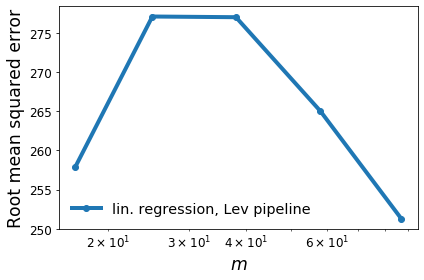

In [16]:
plt.ylabel('Root mean squared error')
plt.xlabel('$m$')
plt.semilogx(m ,err, 'o-', label='lin. regression, Lev pipeline')
plt.legend(frameon=False)

The data indicates that the linear regression model with the `Lev` pipeline (which combines the `Richard` and `Julian` pipelines) gives the best results.

#### progression free survival

In [17]:
benchmark_result = benchmark_pipelines(
    pipelines, X_train, y_train["PFS_days"], X_test, y_test["PFS_days"], metric=rmse
)
benchmark_result

,Richard_test,Julian_test,Freeman_test,Lev_test
DecisionTreeRegressor,350.008600,272.840127,353.411842,297.691983
RandomForestRegressor,303.547547,293.009093,294.235147,288.528707
GradientBoostingRegressor,284.497150,283.096726,287.819347,279.997963
KNeighborsRegressor,343.366697,320.053519,336.517371,313.675739
ElasticNet,274.675298,288.689546,274.302201,280.051230
LinearRegression,277.471223,290.240609,949.174965,275.197068
SVR,298.715156,298.448391,298.710170,298.580264
DummyRegressor,298.722543,298.722543,298.722543,298.722543


- $\Delta \tau$ 
- Calculation of $\Delta \tau$ for various phenotypes.
- Tuning of pipeline.
- Somatic vs all
- Hybrid model best performance.
### Decypher effects of input features

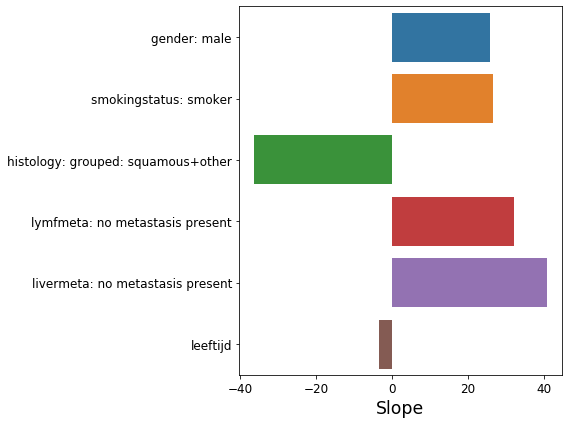

In [18]:
p_richard = pipelines['ElasticNet']['Richard']
view_linear_model_richard(pipeline=p_richard)

[  762.1618855  -4633.10864444 -1932.37612979    51.93213026
 -4715.04551212]


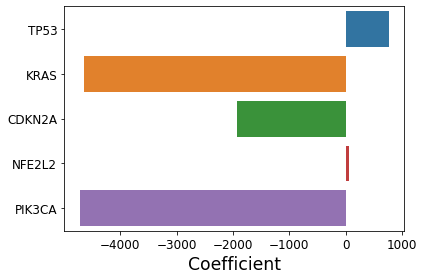

In [19]:
p_julian = pipelines['LinearRegression']['Julian']
classifier = p_julian.steps[-1][1]
column_names = p_julian.steps[-2][1].columns_to_keep_
print(classifier.coef_)
with sns.plotting_context(font_scale=1.5):
#     plt.figure(figsize=(14, 6))
    plt.xlabel(r"Coefficient")
    sns.barplot(x=classifier.coef_, y=column_names, label="large")
    plt.tight_layout()


The sheer size of the coefficients are related to the size of the input variables (which are calculated using the harmonic mean). But the positive sign of `TP53` indicates that the presence of this variable is indicative for prolonger survival.

## Classification
**Goal**: Identify patients that don't respond.

These patients we don't have to treat.

In [20]:
y_train_resp = y_train["response_grouped"]
y_test_resp = y_test["response_grouped"]

response_labels = ['non responder (sd+pd)', 'responder (pr+cr)']
pos_label = 'non responder (sd+pd)'

We want to:
- Maximize our predictive capacity, we do this by maximizing the area under receiver operating curve.
- And at the same time, we don't want to deny patients treatment that could potentially benefit.

The latter statement translates to a minimisation of false positives (predicted is non-responder \[=positive\], but is actually a responder \[=false\]).

We use the area under the receiver operating curve $r_{\mathrm{TP}}(r_{\mathrm{FP}})$:
$$
    A = \int_0^1 r_{\mathrm{TP}}(r_{\mathrm{FP}}) \, \mathrm{d}r_{\mathrm{FP}} \, .
$$
to quantify the models predictive capacity.

In [21]:
# We evaluate the predictive capacity using AUC of ROC.
from sklearn.preprocessing import LabelBinarizer
def auc(y_true, y_pred):
    l = LabelBinarizer().fit(y_true)
    return roc_auc_score(l.transform(y_true), l.transform(y_pred), average='weighted')

In [22]:
ps_class = build_classifier_pipelines()

In [23]:
b = benchmark_pipelines(
    ps_class, X_train, y_train_resp, X_test, y_test_resp, metric=auc,
)
b

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


,Richard_test,Julian_test,Freeman_test,Lev_test
DecisionTreeClassifier,0.588123,0.810345,0.609195,0.708812
RandomForestClassifier,0.452107,0.720307,0.653257,0.448276
GaussianNB,0.438697,0.586207,0.689655,0.455939
GradientBoostingClassifier,0.521073,0.500000,0.538314,0.500000
KNeighborsClassifier,0.469349,0.545977,0.545977,0.503831
LogisticRegression,0.618774,0.500000,0.622605,0.618774
SVC,0.500000,0.500000,0.500000,0.500000
DummyClassifier,0.500000,0.500000,0.500000,0.500000


It seems that our `Julian` pipeline using a DecisionTreeClassifier is the overall winner. Let us take a more in depth look at the confusion matrix.

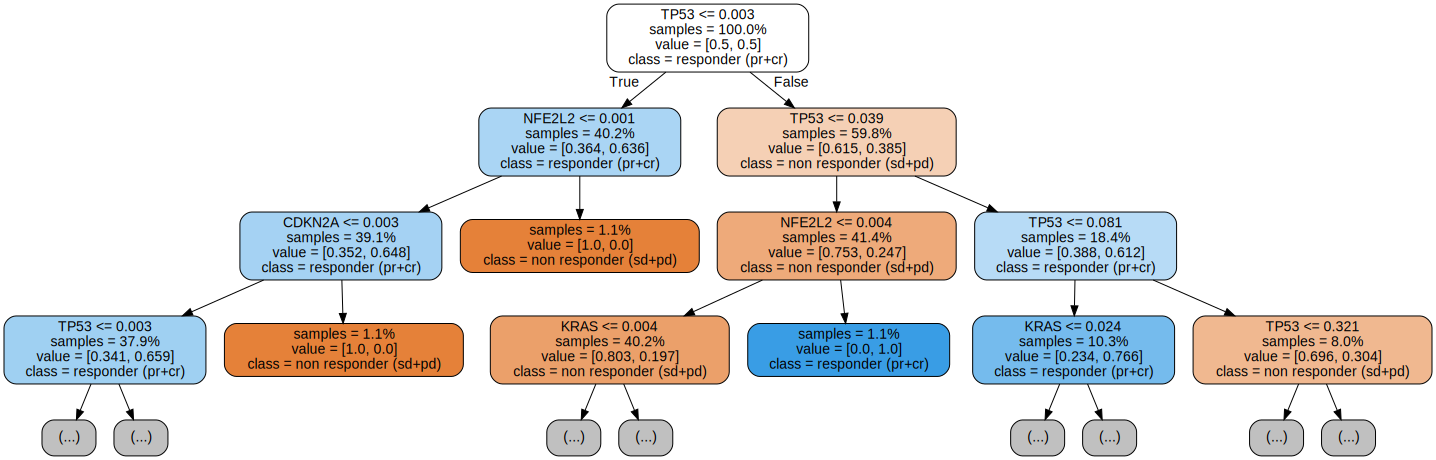

In [24]:
p_win = ps_class['DecisionTreeClassifier']['Julian']
view_decision_tree_julian(p_win, save_to='classifier_tree.png')

Confusion matrix, without normalization
[[18 11]
 [ 0  9]]


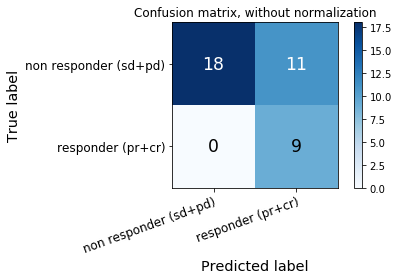

In [25]:
plot_confusion_matrix(y_test_resp, p_win.predict(X_test), classes=response_labels)

### Training size dependence.

In [26]:
p_Julian = ps_class['DecisionTreeClassifier']['Julian']
m, err = evaluate_training_size_dependence(p_Julian, X_train, y_train_resp, X_test, y_test_resp, metric=auc)

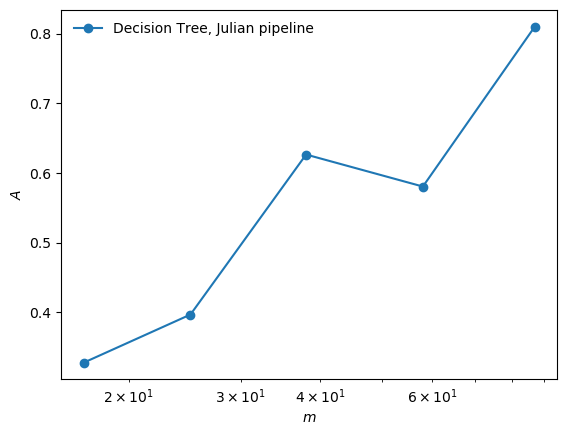

In [27]:
plt.semilogx(m ,err, 'o-', label='Decision Tree, Julian pipeline')
plt.ylabel('$A$')
plt.xlabel('$m$')
plt.legend(frameon=False)

- Tuning of pipeline.
- Precision, recall, $F_1$ and ROC AUC.
- Confusion matrix.
- Somatic vs. all.
- Best model.
- Decypher effects.